# Estimating archaic TMRCAs from the real data

In [107]:
suppressPackageStartupMessages({
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(scales)
library(lemon)
library(cowplot)

devtools::load_all(".")
})

plan(multiprocess, workers = 10)

Loading ychr


In [137]:
samples <- read_info(read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = 3, maxdp = 0.98))

In [2]:
branch_lengths <- future_map_dfr(1:20, function(mindp) {
    gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = mindp, maxdp = 0.98)

    samples <- read_info(gt)

    crossing(
        a = filter(samples, pop == "Africa")$name,
        b = filter(samples, pop != "Africa", pop != "EMH")$name
    ) %>%
    pmap_dfr(function(a, b) {
        x <- gt[, c("chimp", a, b)] %>% filter(complete.cases(.))

        tibble(
            afr = a,
            nonafr = b,
            nonafr_der = sum(x[["chimp"]] == x[[a]] & x[["chimp"]] != x[[b]]),
            afr_der = sum(x[["chimp"]] != x[[a]] & x[["chimp"]] == x[[b]]),
            total = nrow(x)
        )    
    }) %>%
        mutate(mindp = mindp)
})

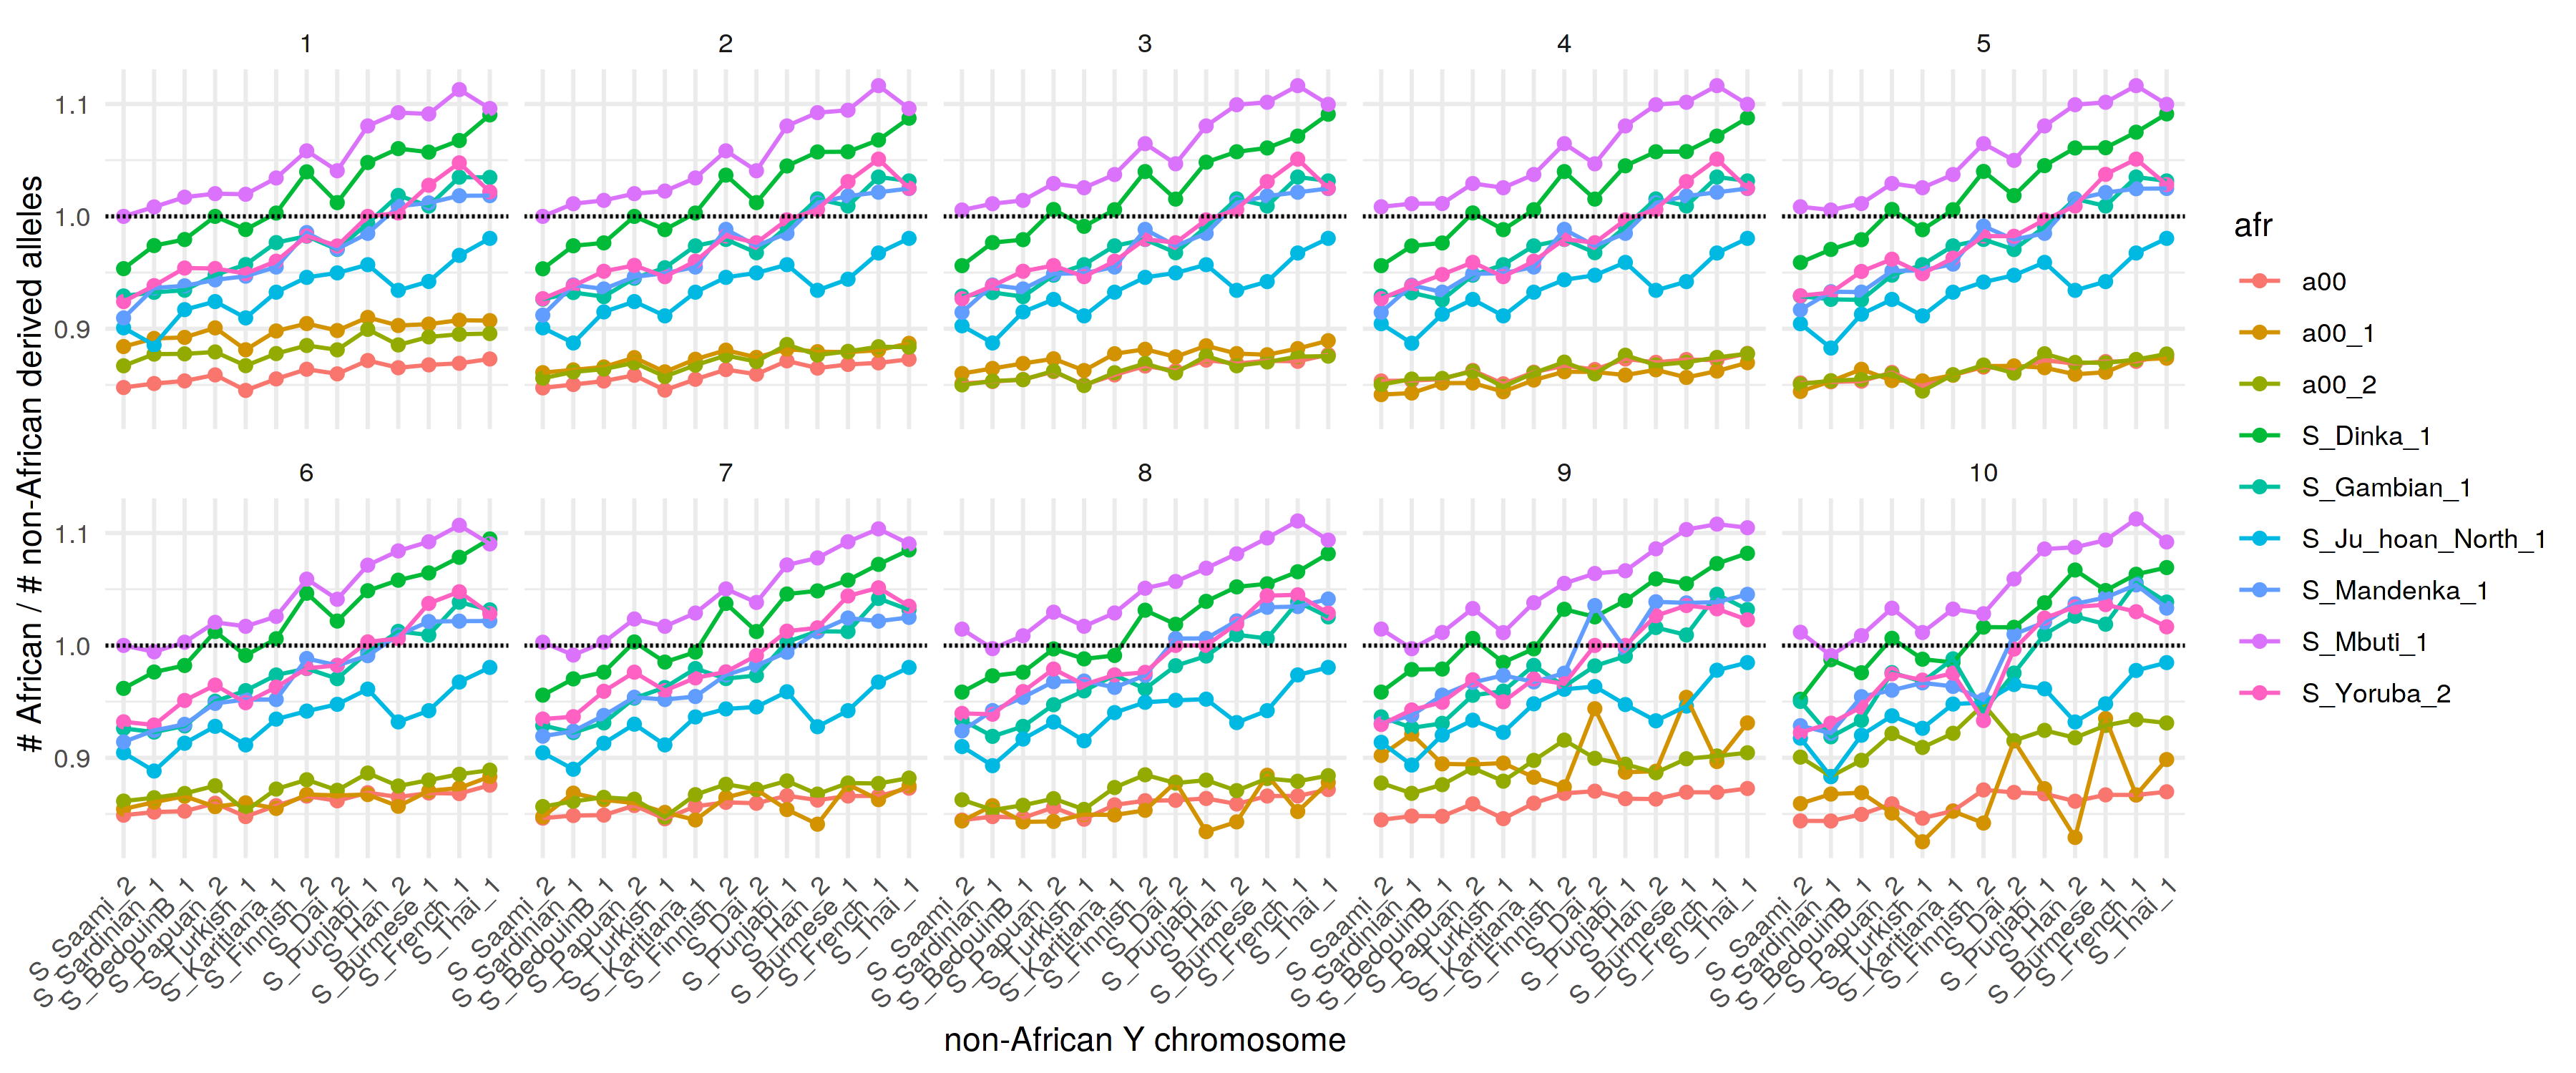

In [3]:
set_dim(12, 5)

branch_lengths %>%
filter(mindp <= 10) %>%
mutate(ratio = afr_der / nonafr_der) %>%
ggplot(aes(fct_reorder(nonafr, ratio), ratio, color = afr, group = afr)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 1, linetype = 2) +
    facet_wrap(~ mindp, nrow = 2) +
    labs(x = "non-African Y chromosome", y = "# African / # non-African derived alleles") +
    theme_minimal() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45))

In [164]:
vcf_c <- read_vcf(here(paste0("data/vcf/full_chimp.vcf.gz")), mindp = 3, maxdp = 0.98)    
head(vcf_c)

ERROR: Error in apply(dp, 2, function(i) ifelse(i >= mindp & i <= quantile(i, : dim(X) must have a positive length


In [163]:
crossing(
    a = filter(samples, pop == "Africa")$name,
    b = filter(samples, pop != "Africa", pop != "EMH")$name
) %>% .[1:2, ] %>%
future_pmap_dfr(function(a, b) {
    vcf_a <- read_vcf(here(paste0("data/vcf/full_", a,                                ".vcf.gz")), mindp = 3, maxdp = 0.98)
    vcf_b <- read_vcf(here(paste0("data/vcf/full_", str_replace(b, "_(\\d)", "-\\1"), ".vcf.gz")), mindp = 3, maxdp = 0.98)
    vcf_c <- read_vcf(here(paste0("data/vcf/full_chimp.vcf.gz")), mindp = 3, maxdp = 0.98)    

    x <-
        inner_join(vcf_a, vcf_b, by = c("chrom", "pos", "REF", "ALT")) %>%
        inner_join(vcf_c, by = c("chrom", "pos", "REF", "ALT")) %>%
        filter(complete.cases(.))

    tibble(
        afr = a,
        nonafr = b,
        nonafr_der = sum(x[["chimp"]] == x[[a]] & x[["chimp"]] != x[[b]]),
        afr_der = sum(x[["chimp"]] != x[[a]] & x[["chimp"]] == x[[b]]),
        total = nrow(x)
    )
})

ERROR: Error in apply(dp, 2, function(i) ifelse(i >= mindp & i <= quantile(i, : dim(X) must have a positive length


In [108]:
afr_dp <- future_map_dfr(1:20, function(mindp) {
    highcov_gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = mindp, maxdp = 0.98)
    run_step1(highcov_gt) %>%
        mutate(mindp = mindp)
})

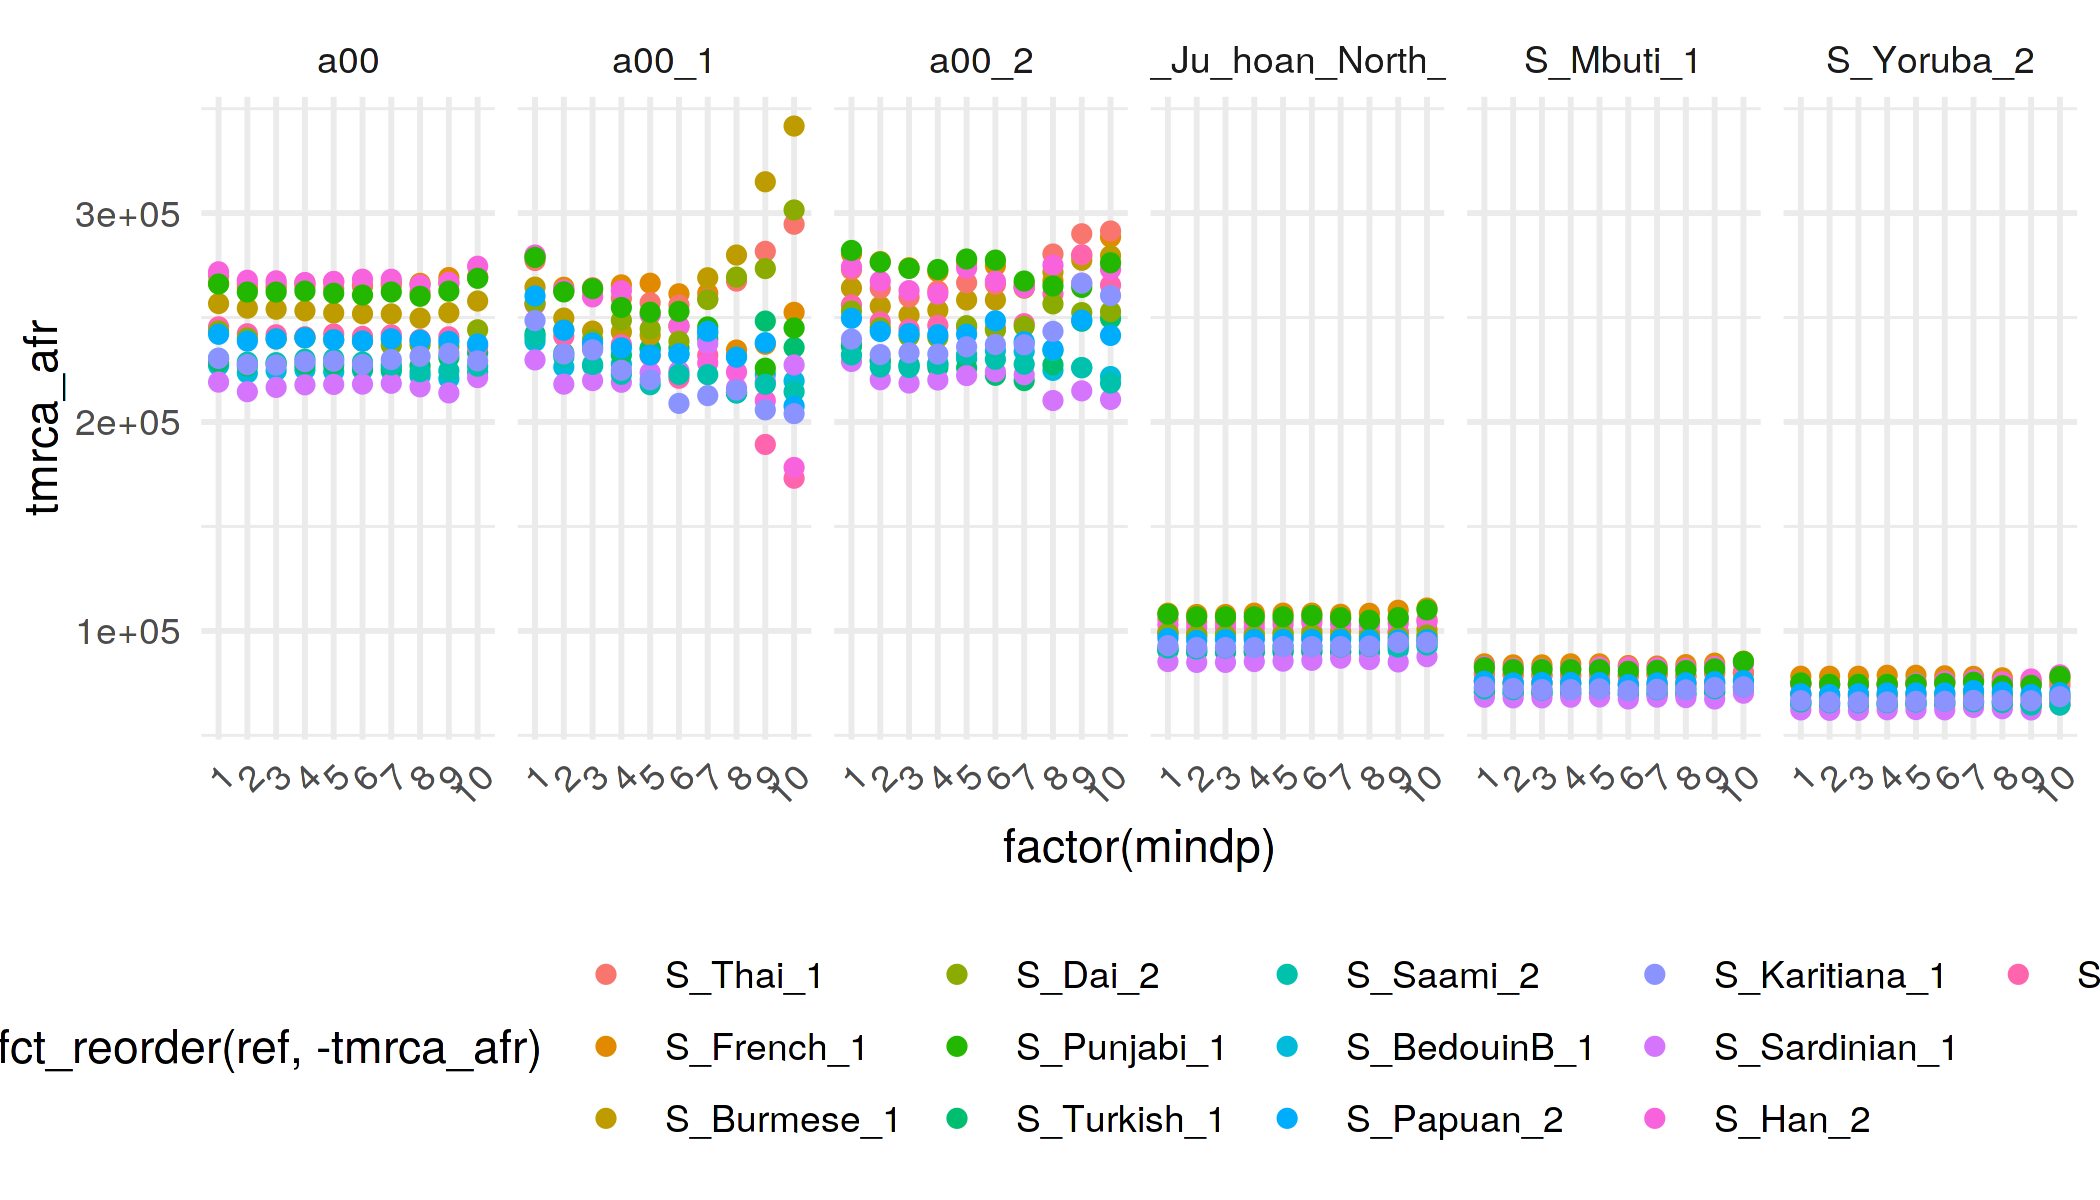

In [130]:
afr_dp %>%
filter(mindp <= 10, !str_detect(afr, "(Mandenka|Gambian|Dinka)")) %>%
ggplot(aes(factor(mindp), tmrca_afr, color = fct_reorder(ref, -tmrca_afr))) +
    geom_point() +
    theme_minimal() +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45)) +
    facet_grid(. ~ afr)

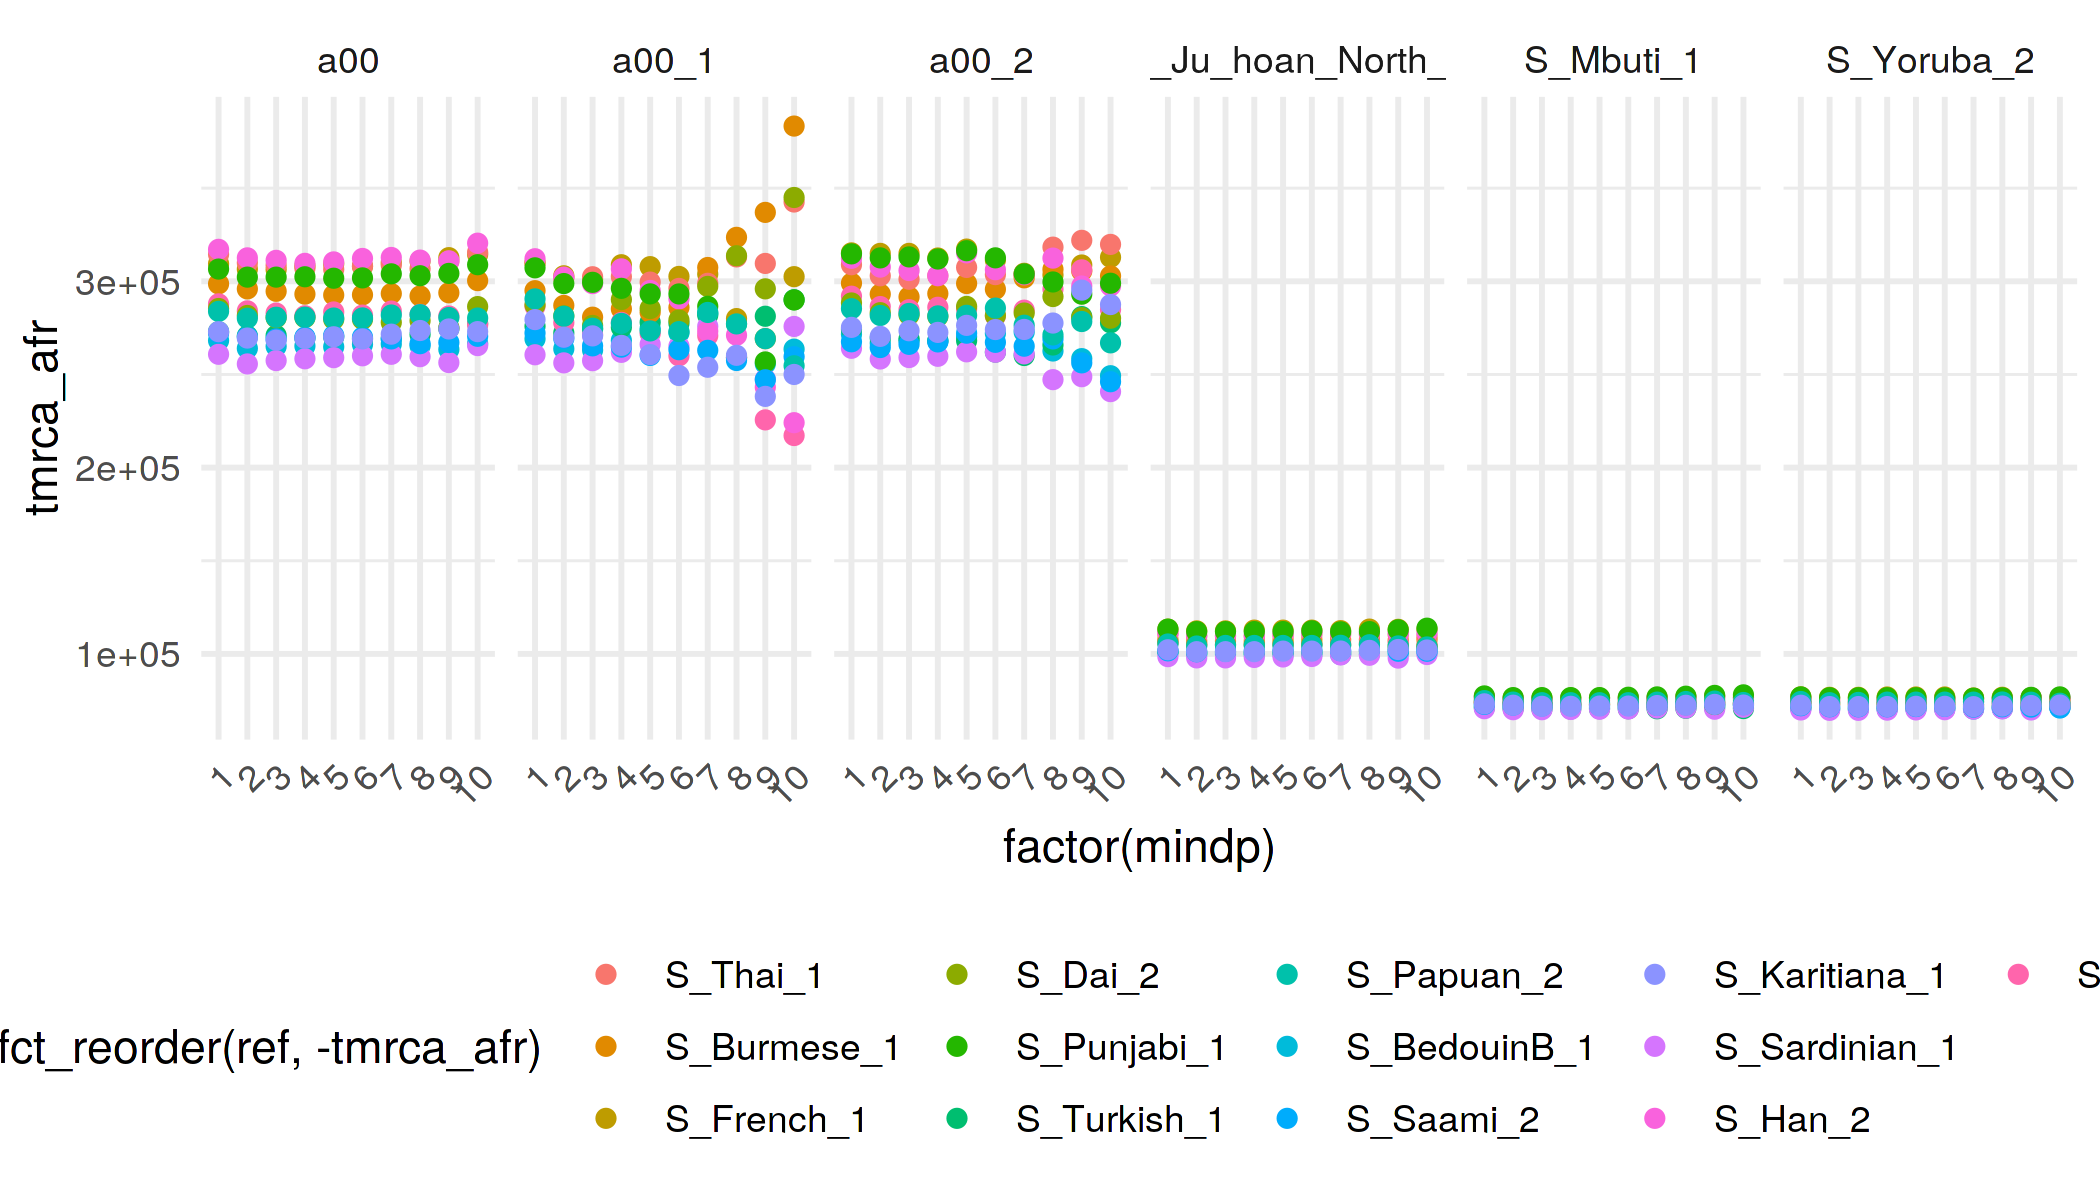

In [135]:
afr_dp %>%
filter(mindp <= 10, !str_detect(afr, "(Mandenka|Gambian|Dinka)")) %>%
mutate(tmrca_afr = (a + d)/(total * mut_rate)) %>% 
ggplot(aes(factor(mindp), tmrca_afr, color = fct_reorder(ref, -tmrca_afr))) +
    geom_point() +
    theme_minimal() +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45)) +
    facet_grid(. ~ afr)

In [2]:
highcov_gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = 3, maxdp = 0.98)

In [3]:
step1 <- run_step1(highcov_gt)

In [4]:
step1 %>% group_by(afr) %>% summarise_if(is.numeric, mean)

afr,a,b,c,d,e,f,total,mut_rate,tmrca_afr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a00,976.00000,1.153846,7.615385,198.4615,11.84615,1002.8462,5785324,7.167527e-10,243052.19
a00_1,936.76923,1.153846,7.461538,194.4615,11.84615,980.1538,5640849,7.193643e-10,242439.68
a00_2,973.46154,1.153846,7.153846,197.6154,12.23077,1002.8462,5762448,7.148795e-10,244702.92
S_Dinka_1,97.92308,2.000000,8.384615,203.0769,12.15385,297.3077,5823451,7.285147e-10,70377.02
S_Gambian_1,101.61538,1.153846,8.230769,204.4615,12.15385,291.0769,5851225,7.303169e-10,68410.84
S_Ju_hoan_North_1,240.07692,2.615385,8.230769,202.1538,12.15385,406.8462,5850920,7.215946e-10,96836.25
S_Mandenka_1,111.46154,1.153846,8.230769,203.3846,12.15385,298.0769,5885064,7.220496e-10,70429.30
S_Mbuti_1,106.92308,1.153846,8.307692,203.3846,12.15385,319.3077,5882409,7.223796e-10,75465.44
S_Yoruba_2,107.61538,1.153846,7.846154,202.0000,11.23077,294.0769,5860753,7.232816e-10,69730.50


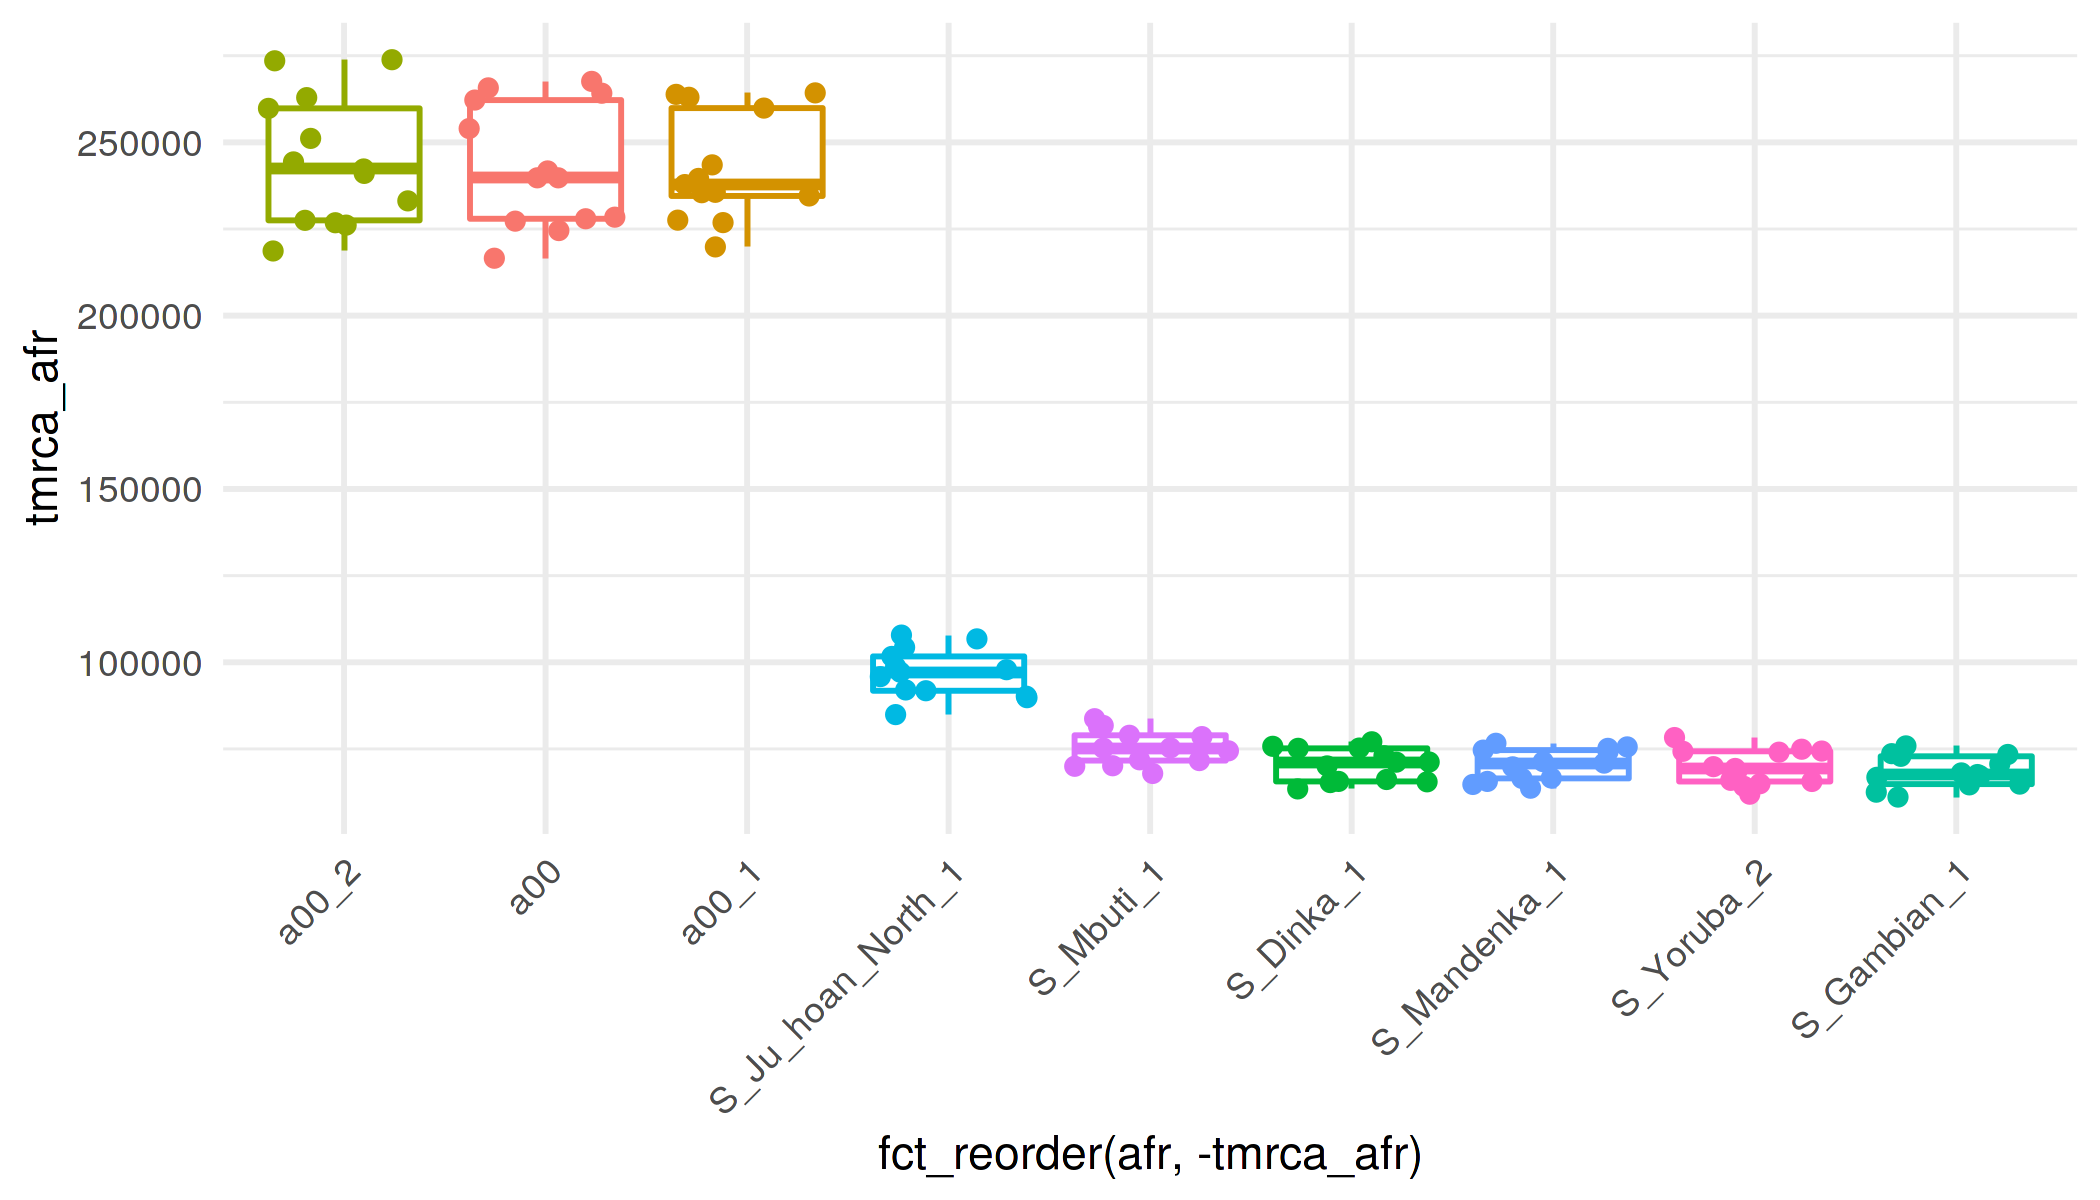

In [106]:
step1 %>%
ggplot(aes(fct_reorder(afr, -tmrca_afr), tmrca_afr, color = afr)) +
    geom_boxplot() +
    geom_jitter() +
    theme_minimal() +
    theme(legend.position = "none", axis.text.x = element_text(hjust = 1, angle = 45))

In [5]:
estimate_grid <- function(samples, regions, mindp) {
    filters <- c("filt50" = "/mnt/454/HighCovNeandertalGenome/Hengs_Alignability_Filter/hs37m_filt35_50.bed.gz",
                 "filt100" = "/mnt/454/HighCovNeandertalGenome/Hengs_Alignability_Filter/hs37m_filt35_99.bed.gz")
    
    map_dfr(samples, function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            map_dfr(c("filt50", "filt100"), function(filt) {
                future_map_dfr(mindp, function(dp) {
                    read_genotypes(arch, regions, mindp = dp, maxdp = 0.98, tv_only = (sites == "tv_only"),
                                   bed_filter = filters[filt]) %>%
                        run_step2(step1) %>%
                        mutate(dp = dp, sites = sites, filt = filt, capture = regions)
                })
            })
        })
    })
}

In [6]:
tmrca_df <- estimate_grid(paste0("mez2_dp", 1:10), "full", 1:10)

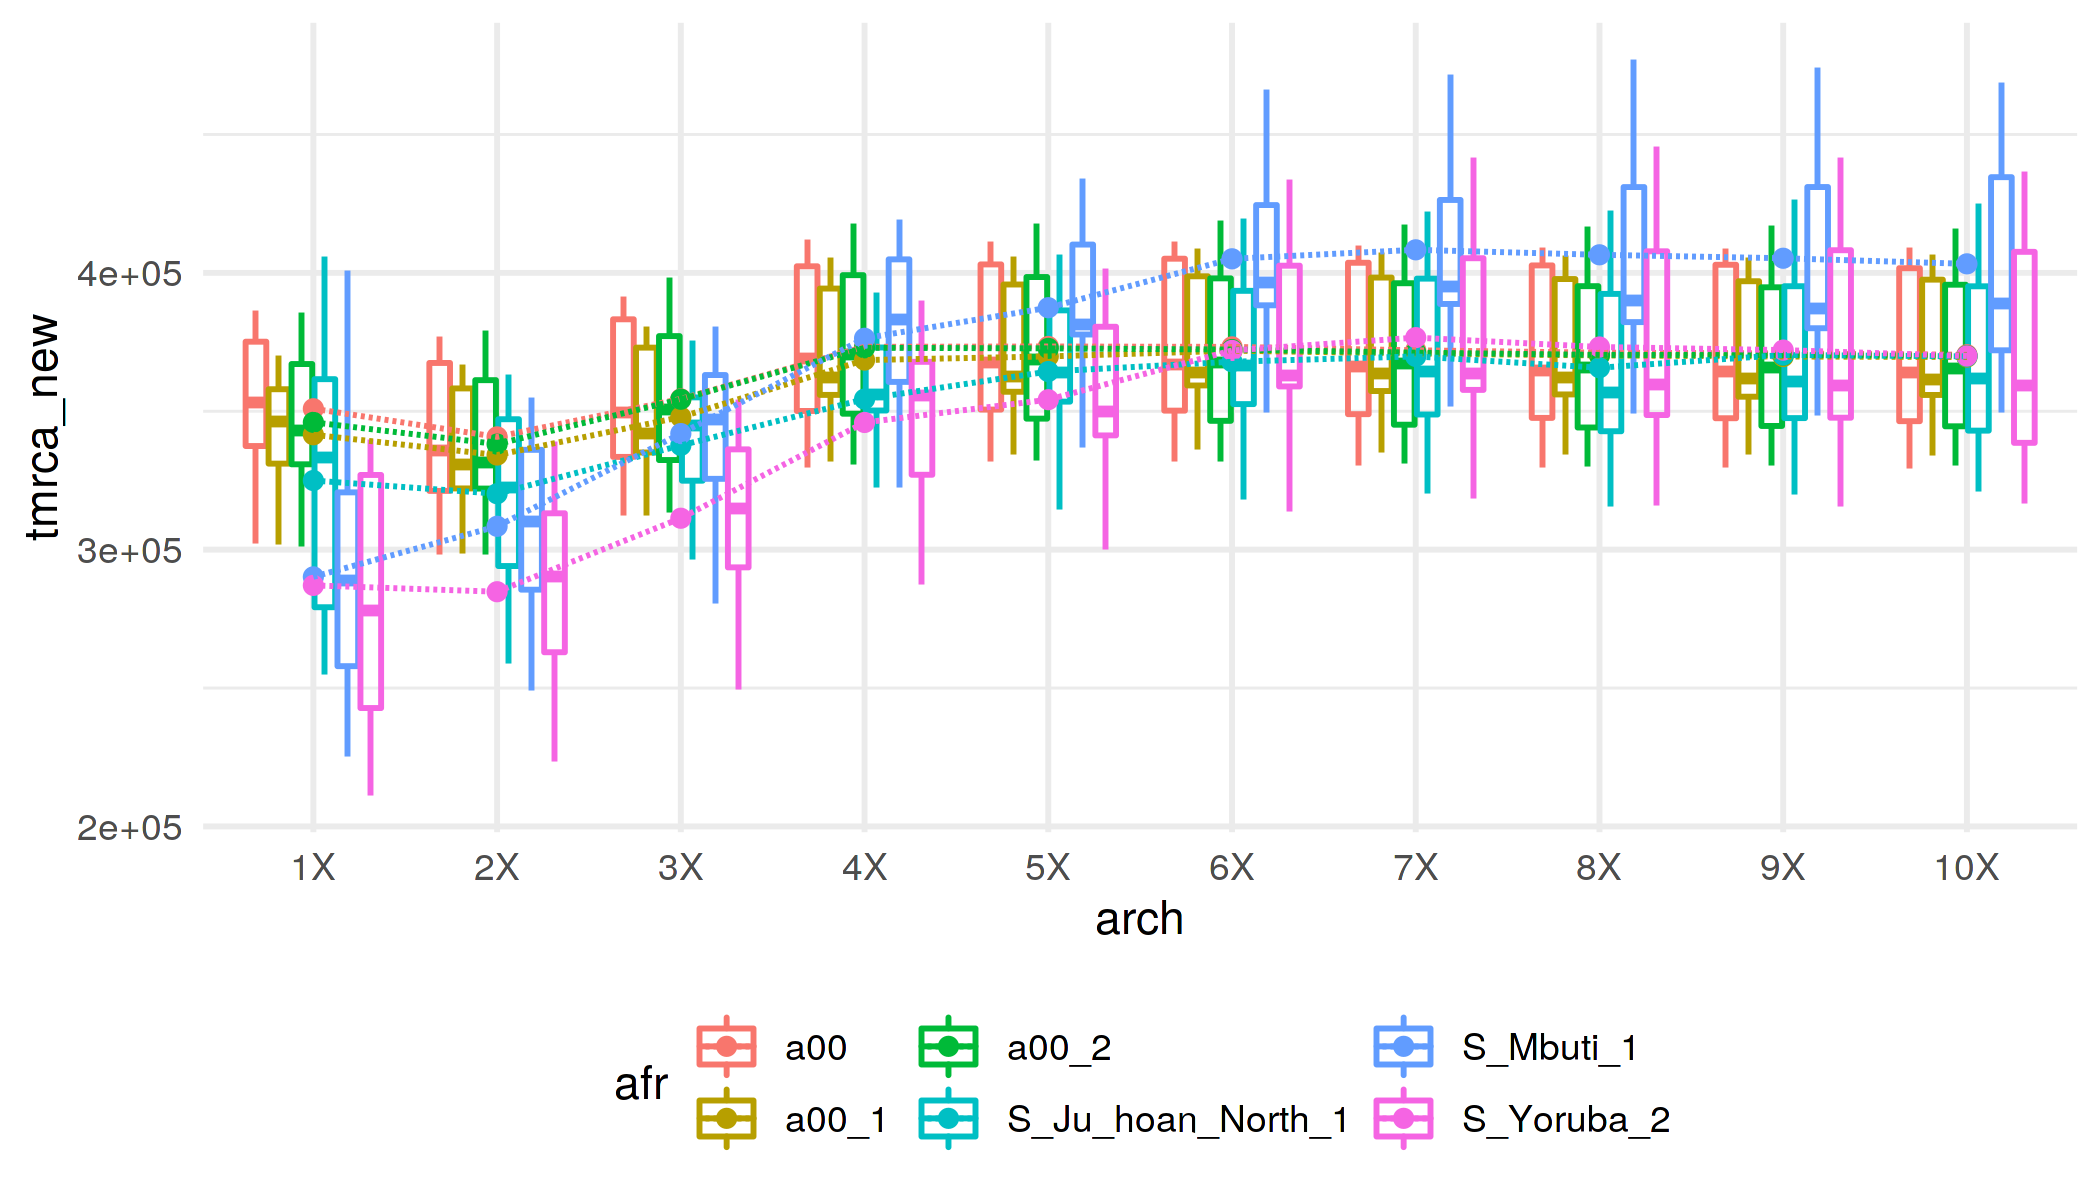

In [98]:
set_dim(7, 4)

tmrca_df %>%
mutate(arch = str_replace(arch, "mez2_dp(\\d+)", "\\1X")) %>% 
filter(dp == 3, capture == "full", sites == "all", filt == "filt50",
      !str_detect(afr, "(Mandenka|Gambian|Dinka)")) %>%
mutate(arch = factor(arch, levels = paste0(1:10, "X"))) %>% {
ggplot(., aes(arch, tmrca_new, color = afr)) +
    geom_boxplot(outlier.shape = NA, alpha = 0.1) +
    geom_point(data = group_by(., arch, afr) %>% summarise_if(is.numeric, mean), aes(arch, tmrca_new)) +
    geom_line(data = group_by(., arch, afr) %>% summarise_if(is.numeric, mean), aes(arch, tmrca_new, group = afr), linetype = 2) +
    theme_minimal() +
    theme(legend.position = "bottom")
}

In [30]:
branches <- tmrca_df %>%
    filter(sites == "all", filt == "filt50", capture == "full", dp <= 8) %>%
    mutate(n_muts = a + b + c + d + e + f) %>%
    select(arch, afr, dp, a, b, c, d, e, f, total, n_muts, sites) %>%
    gather(branch, count, -c(arch, afr, dp, total, n_muts, sites)) %>% 
    mutate(prop = count / n_muts,
           dp = factor(dp)) %>%
    group_by(arch, afr, dp, sites, branch) %>%
    summarise_if(is.numeric, mean)
head(branches)

arch,afr,dp,sites,branch,total,n_muts,count,prop
<chr>,<chr>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
mez2_dp1,a00,1,all,a,3479889,32623.08,1050.15385,0.0321905883
mez2_dp1,a00,1,all,b,3479889,32623.08,46.61538,0.0014289330
mez2_dp1,a00,1,all,c,3479889,32623.08,19.15385,0.0005871398
mez2_dp1,a00,1,all,d,3479889,32623.08,581.46154,0.0178236707
mez2_dp1,a00,1,all,e,3479889,32623.08,593.92308,0.0182057162
mez2_dp1,a00,1,all,f,3479889,32623.08,30331.76923,0.9297639521


Warning message:
“Removed 144 rows containing missing values (geom_point).”

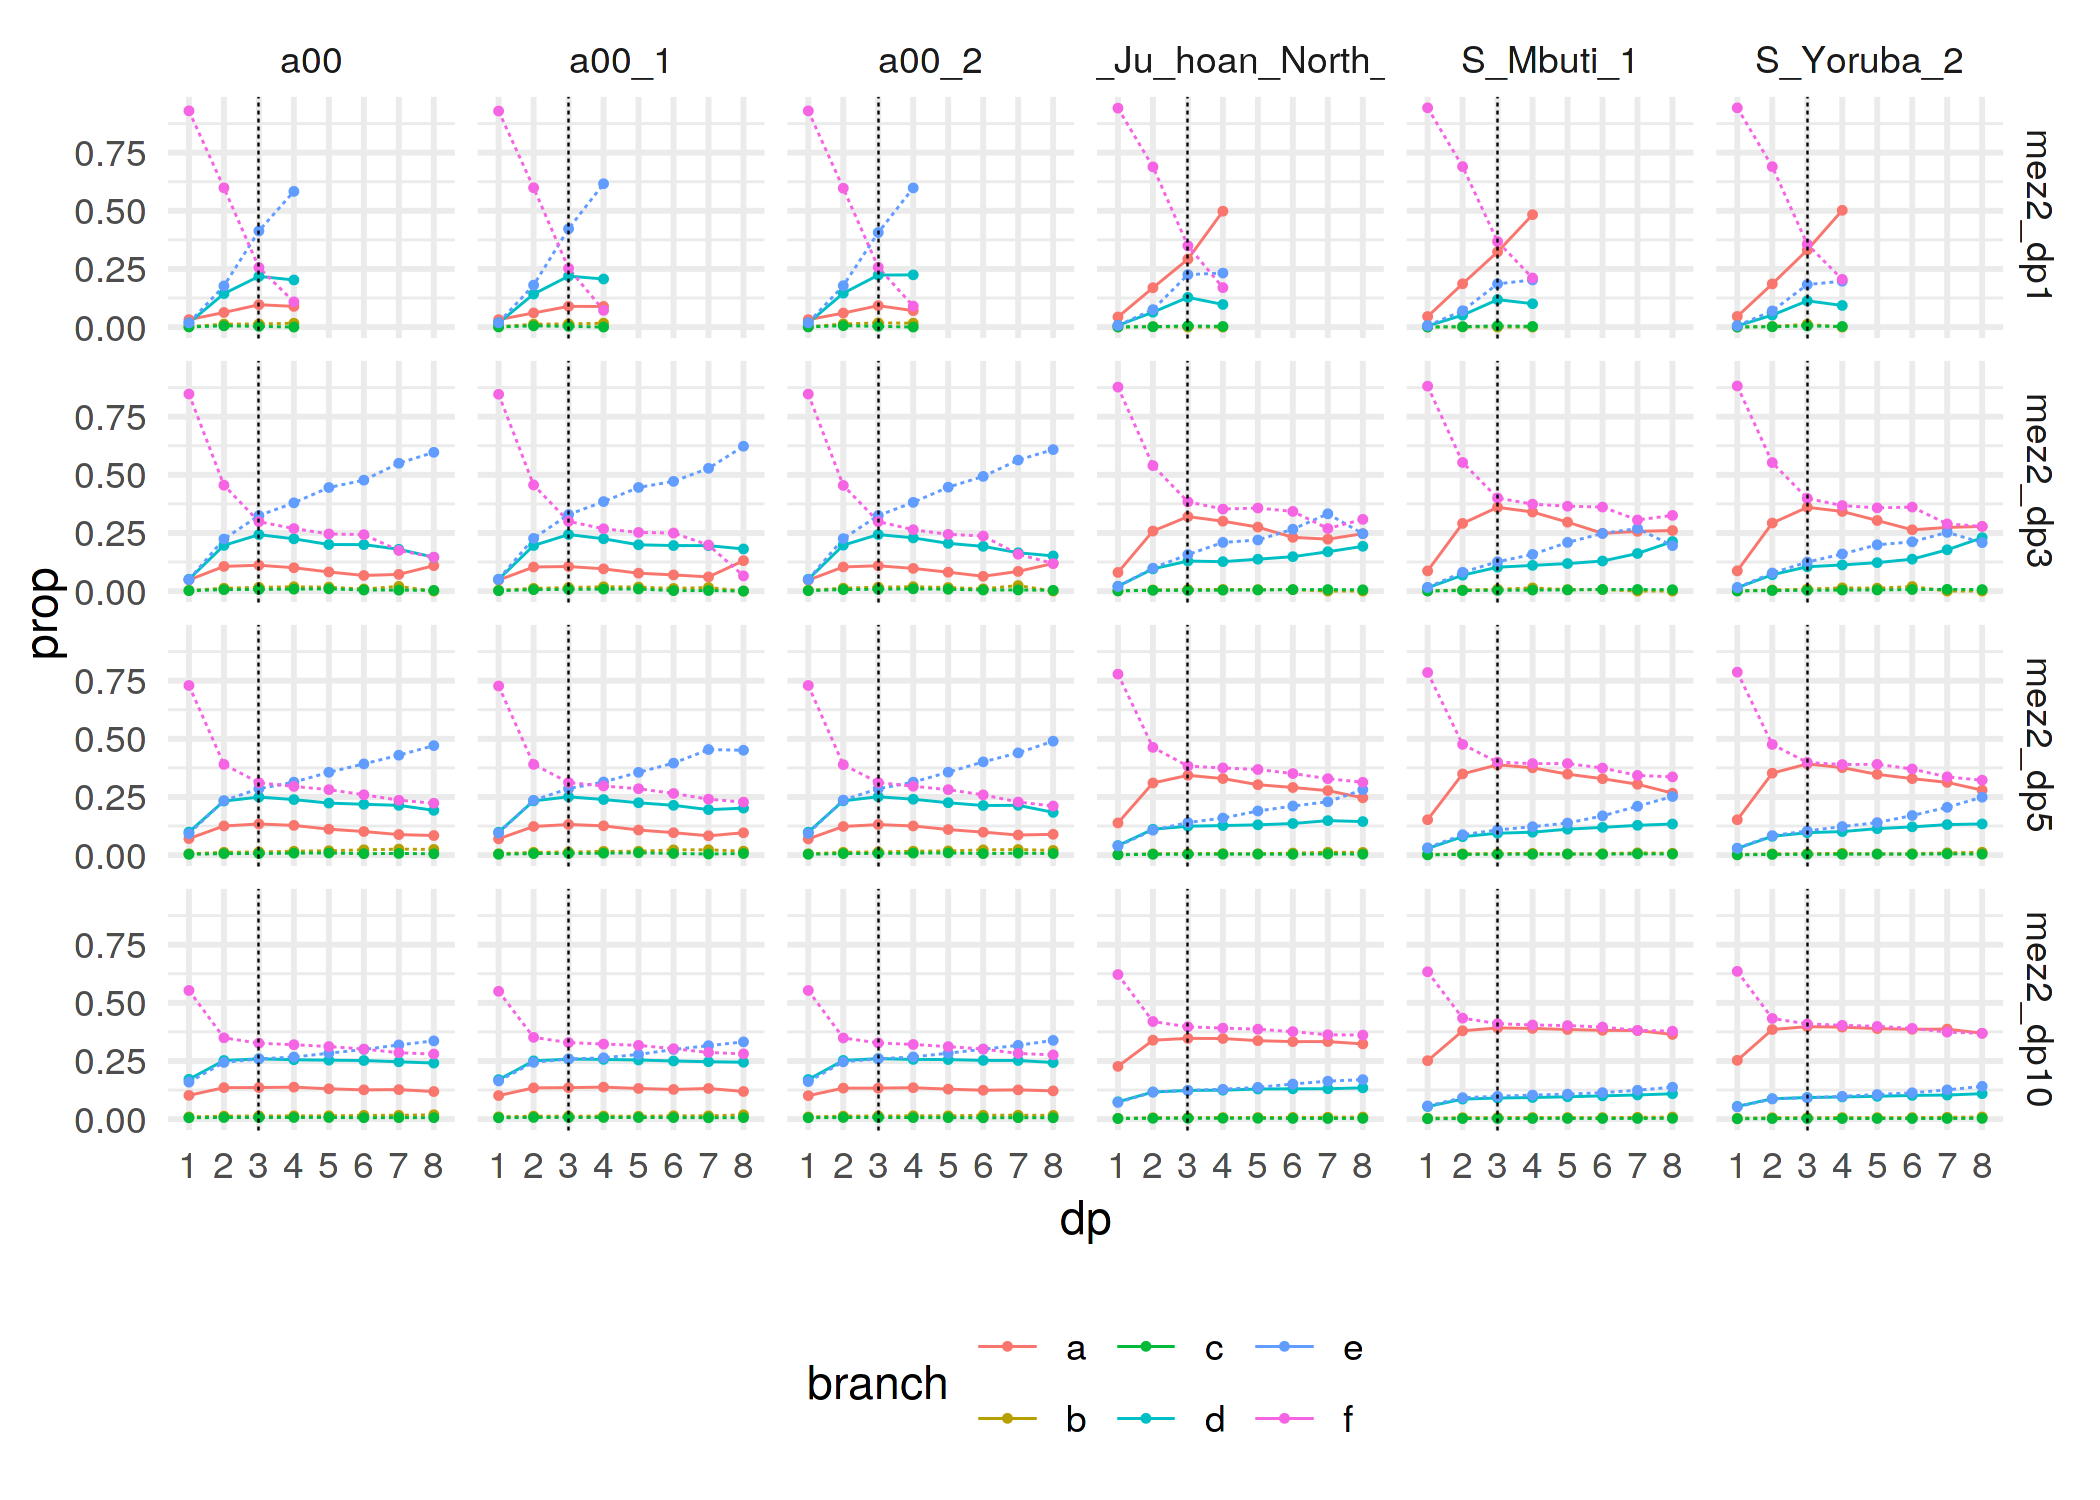

In [86]:
set_dim(7, 5)

branches %>%
ungroup %>%
mutate(arch = factor(arch, levels = paste0("mez2_dp", 1:10))) %>%
filter(
    !str_detect(afr, "(Mandenka|Gambian|Dinka)"),
    arch %in% paste0("mez2_dp", c(1, 3, 5, 10))) %>% {
ggplot() +
    # a and d branches
    geom_line(data = filter(., branch %in% c("a", "d")) %>%
                            group_by(arch, afr, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 1, size = 0.25) +

    # other branches
    geom_line(data = filter(., !branch %in% c("a", "d")) %>%
                            group_by(arch, afr, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 2, size = 0.25) +

    # mean branch count proportions
    geom_point(data = group_by(., arch, afr, dp, sites, branch) %>% summarise_if(is.numeric, mean),
               aes(dp, prop, color = branch), size = 1/3) +

    geom_vline(xintercept = 3, linetype = 2, size = 0.2) +

    theme_minimal() +
    theme(legend.position = "bottom") +

    facet_grid(arch ~ afr)
}